In [54]:
# Quick hack to fix local imports
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

#### Get Input Datasets

In [100]:
import pyrosm
import geopandas as gpd
import numpy as np
import rasterio
import rioxarray as rxr
from matplotlib import pyplot as plt
from shapely.geometry import mapping
from rasterio.crs import CRS

In [156]:
# # Read all boundaries using the default settings
# boundaries = osm.get_boundaries()

# # pick a small subset for testing
# boundary = osm.get_boundaries(name="London Borough of Tower Hamlets")
# boundary.plot()

import geopandas as gpd
from shapely.geometry import box

bbox = box(-0.04, 51.48, 0.011, 51.52)  # a random box around a part of Tower Hamlets and Canary Wharf
boundary = gpd.GeoDataFrame({'geometry': bbox}, index=[0])

In [57]:
# Get London's OpenStreetMap data
fp = pyrosm.get_data("London", update=True)
# Initialize the OSM object 
osm = pyrosm.OSM(fp)

Downloaded Protobuf data 'London.osm.pbf' (66.95 MB) to:
'/tmp/pyrosm/London.osm.pbf'


In [157]:
uk_wp = rxr.open_rasterio('../data/gbr_ppp_2020_UNadj_constrained.tif', masked=True).squeeze()
print(uk_wp.rio.crs)  # make sure the crs is EPSG:4326 (WGS84) to match the unprojected OSM boundary
wp_clipped = uk_wp.rio.clip(boundary.geometry.apply(mapping))

EPSG:4326


In [158]:
# Get the shapely geometry from GeoDataFrame
bbox_geom = boundary['geometry'].values[0]

# Initialise with bounding box
osm = pyrosm.OSM(fp, bounding_box=bbox_geom)

In [159]:
# get all residential buildings as well as ones without a specific tag
residential_filter = {"building": ["residential", "apartments", "flats", "house", "yes"]}
residential_buildings = osm.get_buildings(custom_filter=residential_filter)

In [160]:
# crudely get all places that might be considered workplaces
pois_filter = {"shop": True,"amenity": True, "leisure": True, "tourism": True}
pois = osm.get_pois(custom_filter=pois_filter)
office_filter = {"office": True}
offices = osm.get_data_by_custom_criteria(custom_filter=office_filter)
office_building_filter = {"building": ["office", "offices"]}
office_buildings = osm.get_buildings(custom_filter=office_building_filter)

In [161]:
# combine the locations of all of the crude workplaces
trimmed_households = residential_buildings[['geometry']]
trimmed_workplaces = pois[['geometry']]
trimmed_offices = offices[['geometry']]
trimmed_office_buildings = office_buildings[['geometry']]
trimmed_work = trimmed_workplaces.append(trimmed_offices).append(trimmed_office_buildings)
trimmed_work = trimmed_work.reset_index()
trimmed_work['geometry'] = trimmed_work.geometry.centroid

<ipython-input-161-fa8dc12bfe30>:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  trimmed_work['geometry'] = trimmed_work.geometry.centroid


#### Build Model

In [83]:
import generated.OutbreakSim as gen
import flatbuffers
from geopy import distance

In [84]:
# TODO, nonsense atm
AGENT_SIZE = 32  # in bytes
WORKPLACE_SIZE = 8  # in bytes
HOUSEHOLD_SIZE = 8  # in bytes
CONTAINER_SIZE = 8  # in bytes

initial_buffer_size = (int(wp_clipped.sum())
                       * AGENT_SIZE + len(trimmed_households) 
                       * HOUSEHOLD_SIZE + len(trimmed_work) 
                       * WORKPLACE_SIZE)
print(initial_buffer_size)

821184


In [85]:
builder = flatbuffers.Builder(initial_buffer_size)

In [98]:
res = wp_clipped.rio.resolution()
res = (abs(res[0]), abs(res[0]))
print(res)  # Should be (0.0008333333300256096, 0.0008333333300256096)

(0.0008333333300256096, 0.0008333333300256096)


In [153]:
count = 0
people = []
for row in range(wp_clipped.shape[0]):
    for col in range(wp_clipped.shape[1]):
        count += 1
        
        index = (row, col)
        item = wp_clipped[row, col]
        
        # get the bounding box of the cell
        (minx, miny, maxx, maxy) = (item.x - (res[0] / 2), item.y - (res[1] / 2), 
                                     item.x + (res[0] / 2), item.y + (res[1] / 2))
        
        if np.isnan(item):
            continue
            
        
        local_residences = residential_buildings.cx[minx:maxx, miny:maxy]
        
        print(local_residences)
        
        for ind in range(int(item)):
            continue
            
        if count > 2:
            break
    if count > 2:
            break

Empty GeoDataFrame
Columns: [addr:city, addr:country, addr:housenumber, addr:housename, addr:postcode, addr:street, email, name, opening_hours, operator, phone, website, building, amenity, building:levels, building:material, height, internet_access, landuse, office, shop, source, start_date, wikipedia, id, timestamp, version, geometry, tags, osm_type, changeset]
Index: []

[0 rows x 31 columns]


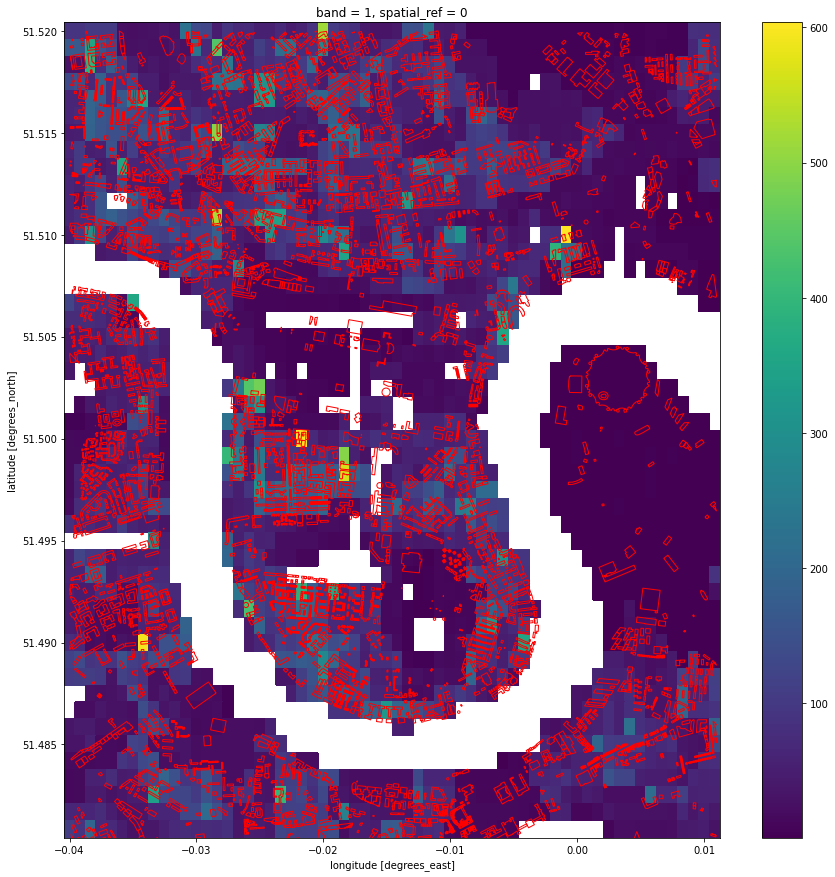

In [162]:
fig, ax = plt.subplots(figsize=(15, 15))
wp_clipped.plot(ax=ax)
residential_buildings.plot(ax=ax, facecolor='none', edgecolor='r');

In [126]:
wp_clipped.shape

(14, 33)